In [1]:
import math
import matplotlib.pyplot as plt
import random
import time
import copy
import heapq

In [105]:
#maxheap
def my_heappush(heap, elem):
    heapq.heappush(heap, (-elem[0], elem[1]))
    
def my_heappop(heap):
    res=heapq.heappop(heap)
    return (-res[0], res[1])

def intertwine_heap_list(heap, _list):
    for x in _list:
        my_heappush(heap, x) 

def get_some_randomness(l, r, elems):
    indexes=list(range(l, r))
    random.shuffle(indexes)
    return indexes[:elems]

class Vertex:
    def __init__(self, v, preve=-1, nexte=-1):
        self.value=v
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
        
    def exchange(self, preve, nexte):
        self.present=False
        if preve!=-1:
            self.present=True
        self.prev=preve
        self.next=nexte
            
    def check_consistency(self, vertexes):
        if not self.present:
            return
        if not vertexes[self.prev].next==self.value or not vertexes[self.next].prev==self.value:
            print(f"DUPA {self.value}")
    
    def __str__(self):
        return f'{self.value}: <{self.prev}, {self.next}>'
        
class Pathway:
    def _greedy_closest_neigh_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]<self.matrix[last][cur]:
            return True
        return False
    
    def _greedy_cycle_comparer(self, last, start, cur, compared):
        if self.matrix[last][compared]+self.matrix[start][compared]<self.matrix[last][cur]+self.matrix[start][cur]:
            return True
        return False

    def _get_maxes(self, v1, v2):
        if self._maxes[0]['place']==v1 or self._maxes[0]['place']==v2:
            if self._maxes[1]['place']==v1 or self._maxes[1]['place']==v2:
                return self._maxes[2]
            return self._maxes[1]
        return self._maxes[0]
    
    def _formulate_maxes(self):
        maxes=[]
        for x in self.vertexes:
            if x.present==False:
                continue
            maxes.append({'value':self.matrix[x.prev][x.value]+self.matrix[x.value][x.next]-self.matrix[x.prev][x.next], 'place':x.value})
        self._maxes=sorted(maxes, key=lambda x: x['value'], reverse=True)[:3]
        
    def _formulate_best(self):
        lst=[]
        for x in self.matrix:
            lst.append([y[0] for y in sorted(list(enumerate(x)), key=lambda x:x[1])[1:6]])
        self.closer=lst
            
    def _double_regret(self, pathway, j, k=2, cnst=1):
        regrets=[]
        ln=len(pathway)
        for i in range(0, ln):
            v1=pathway[i]
            v2=pathway[(i+1)%ln]
            regrets.append((self.matrix[v1][j]+self.matrix[v2][j]-self.matrix[v1][v2], i))
        regrets=sorted(regrets, key=lambda x: x[0])

        sum_of_regrets=-cnst*regrets[0][0]#-regrets[0][0]
        for i in range(1, min(ln, k)):
            sum_of_regrets=sum_of_regrets+regrets[i][0]-regrets[0][0]
        return sum_of_regrets, regrets[0][1]+1


    def _general_heuristic(self, start, comparer, regrets=False, k_reg=2, cnst=1):
        ln=len(self.matrix)//2
        allez=len(self.matrix)
        last, elems, cur, path, devoured=start, 1, -1, [start], [0]*allez
        devoured[start]=1
        fortress_of_regrets=[0, -1]

        while len(path)<ln:
            for j in range(allez):
                if devoured[j]==1:
                    continue

                if regrets==True:
                    partial_regret=comparer(path, j, k_reg, cnst)
                    if cur==-1 or partial_regret[0]>fortress_of_regrets[0]:
                        fortress_of_regrets=partial_regret
                        cur=j
                if regrets==False and (cur==-1 or comparer(last, path[0], cur, j)):
                    cur=j

            last, cur=cur, -1
            devoured[last]=1
            if regrets==False:
                path.append(last)
            else:
                path.insert(fortress_of_regrets[1], last)
            fortress_of_regrets=[0, -1]
        return path
    
    def _vertex_list_to_path(self):
        ln=self.halfway
        path=[]
        for i in range(len(self.matrix)):
            if self.vertexes[i].present==False:
                continue
            j=self.vertexes[i].next
            
            path=[i, j]
            while self.vertexes[j].next!=i:
                #print(f'ideal: {i}, preve: {self.vertexes[j].prev}, zis: {j}, nexte: {self.vertexes[j].next}')
                if self.vertexes[j].next!=j:
                    j=self.vertexes[j].next
                else:
                    j=self.vertexes[j].prev
                path.append(j)
        return path
    
    def _path_to_vertex_list(self):
        ln=self.halfway
        vertexes=[]
        for i in range(len(self.matrix)):
            d=Vertex(i)
            vertexes.append(d)
            
        for i, x in enumerate(self.pathway):
            d=Vertex(x, self.pathway[(i-1)%ln], self.pathway[(i+1)%ln])
            vertexes[x]=d
        return vertexes
    
    
    #Indexes, indexes everywhere; returns literal cost (negata - profit); only one present
    def _cost_swap_vertex(self, v1, v2, bastard='None'):
        if self.vertexes[v2].present: #And its v1 present
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=self._get_maxes(v1, next1)['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        
        if bastard=='None':
            return max(eld-neue, -novel)
        if bastard=='Close':
            return -novel
        if bastard=='Distant':
            return -neue
    
    #Swap v1, v2 with one outside
    def _swap_partial(self, v1, v2, bastard='None'):
        if self.vertexes[v1].prev==-1: #v1 exists always
            tmp=v1
            v1=v2
            v2=tmp
        next1=self.vertexes[v1].next
        post_next=self.vertexes[next1].next
        
        reason=self._get_maxes(v1, next1)
        neue=self.matrix[v1][v2]+self.matrix[v2][next1]-self.matrix[v1][next1]
        eld=reason['value']
        novel=self.matrix[v1][v2]+self.matrix[v2][post_next]-self.matrix[v1][next1]-self.matrix[next1][post_next]
        if (-novel > eld-neue and bastard!='Distant') or bastard=='Close':
            nel=next1
        else:
            nel=reason['place']
        
        self.vertexes[v1].next=v2
        self.vertexes[next1].prev=v2
        self.vertexes[v2].exchange(v1, next1)
        
        pnel=self.vertexes[nel].prev
        nnel=self.vertexes[nel].next
        self.vertexes[pnel].next=nnel
        self.vertexes[nnel].prev=pnel
        self.vertexes[nel].exchange(-1, -1)        
    
    def _swap_by_vertex(self, v1, v2):
        self._swap_partial(v1, v2)
    
    #Next edge after vertex swapped
    def _cost_swap_edges(self, v1, v2, formal_dissolver=False):
        if self.vertexes[v2].prev==v1 or self.vertexes[v2].next==v1:
            return -1
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        neue=self.matrix[v2][v1]+self.matrix[next1][next2]
        eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        if formal_dissolver==True:
            neue=self.matrix[v2][next1]+self.matrix[v1][next2]
            eld= self.matrix[v2][next2]+self.matrix[v1][next1]
        return eld-neue
        
    def _swap_by_edge(self, v1, v2):
        next1=self.vertexes[v1].next
        next2=self.vertexes[v2].next
        
        j=next1
        while j!=next2:
            tmp=self.vertexes[j].prev
            self.vertexes[j].prev=self.vertexes[j].next
            self.vertexes[j].next=tmp
            j=self.vertexes[j].prev
        
        self.vertexes[next1].next=next2
        self.vertexes[next2].prev=next1
        
        self.vertexes[v1].exchange(self.vertexes[v1].prev, v2)
        self.vertexes[v2].exchange(v1, self.vertexes[v2].next)
        
    def _get_properties(self, i, j):
        if i==j or (not self.vertexes[i].present and not self.vertexes[j].present):
            return -1, -1
        if not self.vertexes[i].present or not self.vertexes[j].present:
            coste=self._cost_swap_vertex(i, j)
            return coste, self._swap_by_vertex
        else:
            coste=self._cost_swap_edges(i, j)
            return coste, self._swap_by_edge
                        
            
    def steep(self):
        while True:
            max_gain=0
            for i in range(len(self.matrix)):
                for j in range(i+1, len(self.matrix)):
                    coste, fun=self._get_properties(i, j)
                    
                    if coste<max_gain:
                        continue
                    max_gain=coste
                    vals=[fun, i, j]
                    
            if max_gain<=0:
                return
            self.current_cost-=max_gain
            max_gain=0
            vals[0](vals[1], vals[2])
            self._formulate_maxes()
            
    def steep_candid(self):
        while True:
            max_gain=0
            for i in range(len(self.matrix)):
                for j in self.closer[i]:
                    coste, fun=self._get_properties(i, j)
                    
                    if self.vertexes[i].present==True and self.vertexes[j].present==True:
                        x, y=self.vertexes[i].prev, self.vertexes[j].prev
                    elif self.vertexes[i].present==True:
                        x, y=self.vertexes[i].prev, j
                    elif self.vertexes[j].present==True:
                        x, y=i, self.vertexes[j].prev
                    else:
                        x, y=-1, -1
                    coste2, fun2=self._get_properties(x, y)
                    
                    #coste, fun=coste2, fun2   
                    if coste2 > coste and coste2 > max_gain:
                        max_gain=coste2
                        vals=[fun2, x, y]
                        
                    else:
                        if coste<max_gain:
                            continue
                        max_gain=coste
                        vals=[fun, i, j]
                    
            if max_gain<=0:
                return
            self.current_cost-=max_gain
            max_gain=0
            vals[0](vals[1], vals[2])
            self._formulate_maxes()
    
    
    def reformulate_all_heaps(self, orders, only_cut=False):
        #only_cut=False
        for x in orders:
            if self.vertexes[x].present==False:
                for y in range(self._full_len):
                    if x==y or self.vertexes[y].present==False:
                        continue
                    value_cut=self._cost_swap_vertex(y, x, bastard='Close')
                    value_proper=self._cost_swap_vertex(y, x, bastard='Distant')
                    nexto=self.vertexes[y].next
                    my_heappush(self._heaps['heap_v_cut'], (value_cut, [y, x, nexto, self.vertexes[nexto].next]))
                    my_heappush(self._heaps['heap_v'], (value_proper, [y, x, nexto]))
                    
            else:
                for y in range(self._full_len):
                    if x==y:
                        continue
                    if self.vertexes[y].present==False:
                        value_cut=self._cost_swap_vertex(x, y, bastard='Close')
                        value_proper=self._cost_swap_vertex(x, y, bastard='Distant')
                        nexto=self.vertexes[x].next
                        my_heappush(self._heaps['heap_v_cut'], (value_cut, [x, y, nexto, self.vertexes[nexto].next]))
                        if only_cut==False:
                            my_heappush(self._heaps['heap_v'], (value_proper, [x, y, nexto]))
                    elif only_cut==False and self.vertexes[x].next!=y and self.vertexes[x].prev!=y:
                        value_good=self._cost_swap_edges(x, y)
                        value_bad=self._cost_swap_edges(x, y, formal_dissolver=True)
                        my_heappush(self._heaps['heap_e'], (value_good, [[x, self.vertexes[x].next], [y, self.vertexes[y].next]]))
                        my_heappush(self._heaps['heap_e'], (value_bad, [[x, self.vertexes[x].next], [self.vertexes[y].next, y]]))
    
    def initialize_heaps(self):
        heap_names=['heap_v_cut', 'heap_v', 'heap_e']
        self._heaps={}
        for x in heap_names:
            self._heaps[x]=[]
            
        for x in range(self._full_len):
            if self.vertexes[x].present==False:
                continue
            self.reformulate_all_heaps([x])
    
    def get_best_v_cut(self):
        while len(self._heaps['heap_v_cut'])>0:
            res=my_heappop(self._heaps['heap_v_cut'])
            cut=res[1]
            nexto=self.vertexes[cut[0]].next
            if self.vertexes[cut[0]].present==True and self.vertexes[cut[1]].present==False and nexto==cut[2] and self.vertexes[cut[2]].next==cut[3]:
                intertwine_heap_list(self._heaps['heap_v_cut'], [res])
                return res[0], [[cut[0], cut[1], cut[2]], [self.vertexes[cut[0]].prev]], [self._swap_partial, [cut[0], cut[1], 'Close']]
        return -1, -1, -1
    
    def get_best_v(self):
        while len(self._heaps['heap_v'])>0:
            res=my_heappop(self._heaps['heap_v'])
            cut=res[1]
            nexto=self.vertexes[cut[0]].next
            if self.vertexes[cut[0]].present==True and self.vertexes[cut[1]].present==False and nexto==cut[2]:
                mx=self._get_maxes(cut[0], cut[1])
                preve=self.vertexes[mx['place']].prev
                intertwine_heap_list(self._heaps['heap_v'], [res])
                return mx['value']+res[0], [[cut[0], cut[1], mx['place'], preve], [self.vertexes[cut[0]].prev, self.vertexes[preve].prev]], [self._swap_partial, [cut[0], cut[1], 'Distant']]
        return -1, -1, -1
            
    def get_best_e(self):
        withhold=[]
        while len(self._heaps['heap_e'])>0:
            res=my_heappop(self._heaps['heap_e'])
            cut=res[1]
            a, next_a = cut[0]
            b, next_b = cut[1]
            
            if self.vertexes[a].present==True and self.vertexes[b].present==True and self.vertexes[a].next==next_a and self.vertexes[b].next==next_b:
                withhold.append(res)
                intertwine_heap_list(self._heaps['heap_e'], withhold)
                return res[0], [[a, b], [self.vertexes[a].prev, self.vertexes[b].prev]], [self._swap_by_edge, [a, b]]
            
            elif self.vertexes[a].present==True and self.vertexes[b].present==True and (self.vertexes[a].next==next_a or self.vertexes[a].prev==next_a) and (self.vertexes[b].next==next_b or self.vertexes[b].prev==next_b):
                withhold.append(res)
        intertwine_heap_list(self._heaps['heap_e'], withhold)
        return -1, -1, -1

    
    def get_best(self):
        gain1, info1, code1=self.get_best_v_cut()
        gain2, info2, code2=self.get_best_v()
        gain3, info3, code3=self.get_best_e()
        if gain1 >= gain2 and gain1>=gain3:
            return gain1, info1, code1
        if gain2 >= gain3:
            return gain2, info2, code2
        return gain3, info3, code3
    
    def steep_heapov(self):
        self.initialize_heaps()
        while True:
            max_gain=0
            max_gain, info, code=self.get_best() #Vertexes: b - added - thus update a->s, b->s; also c if nexto changed
            
            if max_gain<=0:
                return
            self.current_cost-=max_gain
            
            max_gain=0
            code[0](*code[1])
            self._formulate_maxes()
            self.reformulate_all_heaps(info[0])
            self.reformulate_all_heaps(info[1], only_cut=True)
    
    
    def execute_optimizer(self, name, params):
        _methods={
            #'greed':self.greed,
            'steep':self.steep,
            'steep_candid':self.steep_candid,
            'steep_heap':self.steep_heapov
        }
        _methods[name](*params)
        self.pathway=self._vertex_list_to_path()
    
    def cost(self):
        ln=self.halfway
        summa=0
        for i,x in enumerate(self.pathway):
            print(i, self.pathway[i], self.pathway[(i+1)%ln])
            summa+=self.matrix[x][self.pathway[(i+1)%ln]]
        return summa
    
    
    def __init__(self, matrix, constr_method_and_args, start):
        _methods={
            'greedy closest neigh':self._greedy_closest_neigh_comparer,
            'greedy cycle':self._greedy_cycle_comparer,
            'k regret':self._double_regret,
            'random':'random'
        }
        self.halfway=len(matrix)//2
        self._full_len=len(matrix)
        
        self.matrix=matrix
        method=_methods[constr_method_and_args[0]]
        if  method=='random':
            self.pathway=get_some_randomness(1, len(matrix), self.halfway)
        else:
            self.pathway=self._general_heuristic(start, method, *constr_method_and_args[1:])
        self.current_cost=-1
        self.current_cost=self.cost()
        self.vertexes=self._path_to_vertex_list()
        self.pathway=self._vertex_list_to_path()
        self._formulate_maxes()
        self._formulate_best()


In [106]:
def read_tsp(filename):
    res=[]
    with open(filename) as falka:
        x=falka.readline()
        while x:
            res.append(x)
            x=falka.readline()
    res=res[6:-1]
    res=[x[:-1].split(' ') for x in res]
    res=[[int(y) for y in x] for x in res]
    return res

def calc_matrix(res):
    C=len(res)
    matrix=[]
    for i in range(C):
        matrix.append([0]*C)

    for i in range(C):
        for j in range(C):
            matrix[i][j]=(res[i][1]-res[j][1])*(res[i][1]-res[j][1])+(res[i][2]-res[j][2])*(res[i][2]-res[j][2])
            matrix[i][j]=round(math.sqrt(matrix[i][j]))
    return matrix

def systematize(file_namez):
    properties={}
    for value in file_namez:
        x=file_namez[value]
        properties[x]={}
        properties[x]['res']=read_tsp(value)
        properties[x]['matrix']=calc_matrix(properties[x]['res'])
    return properties

    
file_namez={'../kroA200.tsp':'kroA200.tsp', '../kroB200.tsp':'kroB200.tsp'}
properties=systematize(file_namez)

In [107]:
#reality=[('greed', ['greedy closest neigh']), ('cycle', ['greedy cycle']), 
#        ('2reg-1', ['k regret', True, 2, 0]), ('2reg-2', ['k regret', True, 2, 1]), ('random', ['random'])]

Inf=1000000000
def append_starter(dct, res, iters, name='res'):
    dct['min_'+name]=min(dct['min_'+name], res)
    dct['max_'+name]=max(dct['max_'+name], res)
    dct['avg_'+name]=res/iters+dct['avg_'+name]
    
def append_later(dct, res, path, zeit, iters):
    if res<dct['min_res']:
        dct['path']=path
    append_starter(dct, res, iters)
    append_starter(dct, zeit, iters, 'time')
    
def create_fields(dct, elem, namez):
    dct[elem]={}
    for x in namez:
        dct[elem]['min_'+x]=Inf
        dct[elem]['max_'+x]=0
        dct[elem]['avg_'+x]=0

post_reality=[('random', ['random'])]
reality=[('steep with heap', ['steep_heap']), ('steep', ['steep']), ('steep with candidates', ['steep_candid'])]
#reality=[('steep with heap', ['steep_heap'])]

max_zeit=0
system={}
system_starter={}

iters=10
for falka in range(iters):
    print(f'iteracja nr {falka}')
    for x in properties:
        matrix=properties[x]['matrix']
        for alpha in post_reality:
            ts=time.time()
            if alpha[0]=='random':
                basic_path=Pathway(matrix, alpha[1], -1)
            else:
                basic_path=-1
                for i in range(len(matrix)):
                    some_neo_path=Pathway(matrix, alpha[1], i)
                    if basic_path==-1 or some_neo_path.cost()<basic_path.cost():
                        basic_path=some_neo_path
                        
            t_all=time.time()-ts
            if (x, alpha[0]) not in system_starter:
                create_fields(system_starter, (x, alpha[0]), ['res'])
            append_starter(system_starter[(x, alpha[0])], basic_path.cost(), iters)

            for y in reality:
                if (x, alpha[0], y[0]) not in system:
                    create_fields(system, (x, alpha[0], y[0]), ['res', 'time'])

                some_path=copy.deepcopy(basic_path)
                t1=time.time()
                some_path.execute_optimizer(y[1][0], y[1][1:])
                way=some_path.pathway
                t2=time.time()-t1+t_all
                if(t2>max_zeit):
                    max_zeit=t2

                append_later(system[(x, alpha[0], y[0])], some_path.cost(), some_path.pathway, t2, iters)

iteracja nr 0
0 124 142
1 142 58
2 58 31
3 31 51
4 51 74
5 74 77
6 77 18
7 18 146
8 146 53
9 53 95
10 95 30
11 30 167
12 167 165
13 165 198
14 198 64
15 64 76
16 76 147
17 147 25
18 25 123
19 123 181
20 181 22
21 22 44
22 44 126
23 126 150
24 150 88
25 88 40
26 40 116
27 116 177
28 177 170
29 170 149
30 149 23
31 23 19
32 19 36
33 36 16
34 16 151
35 151 199
36 199 12
37 12 183
38 183 121
39 121 33
40 33 65
41 65 119
42 119 8
43 8 171
44 171 117
45 117 133
46 133 115
47 115 145
48 145 179
49 179 148
50 148 56
51 56 84
52 84 158
53 158 97
54 97 79
55 79 155
56 155 49
57 49 93
58 93 196
59 196 50
60 50 75
61 75 21
62 21 128
63 128 176
64 176 73
65 73 67
66 67 174
67 174 17
68 17 131
69 131 38
70 38 178
71 178 94
72 94 100
73 100 47
74 47 13
75 13 162
76 162 182
77 182 37
78 37 4
79 4 69
80 69 55
81 55 185
82 185 87
83 87 197
84 197 106
85 106 137
86 137 175
87 175 78
88 78 35
89 35 118
90 118 127
91 127 11
92 11 5
93 5 159
94 159 96
95 96 111
96 111 129
97 129 52
98 52 24
99 24 124
0 199 

0 198 130
1 130 177
2 177 93
3 93 179
4 179 56
5 56 6
6 6 83
7 83 57
8 57 185
9 185 195
10 195 51
11 51 115
12 115 162
13 162 53
14 53 153
15 153 190
16 190 114
17 114 36
18 36 79
19 79 19
20 19 37
21 37 151
22 151 107
23 107 20
24 20 89
25 89 0
26 0 94
27 94 97
28 97 31
29 31 166
30 166 174
31 174 58
32 58 135
33 135 98
34 98 7
35 7 28
36 28 141
37 141 188
38 188 38
39 38 148
40 148 69
41 69 197
42 197 66
43 66 196
44 196 39
45 39 116
46 116 189
47 189 110
48 110 48
49 48 85
50 85 137
51 137 133
52 133 180
53 180 29
54 29 74
55 74 149
56 149 100
57 100 126
58 126 123
59 123 64
60 64 140
61 140 172
62 172 138
63 138 87
64 87 170
65 170 103
66 103 143
67 143 152
68 152 23
69 23 161
70 161 95
71 95 136
72 136 18
73 18 150
74 150 91
75 91 118
76 118 35
77 35 44
78 44 16
79 16 191
80 191 186
81 186 125
82 125 12
83 12 154
84 154 1
85 1 15
86 15 182
87 182 139
88 139 105
89 105 119
90 119 124
91 124 13
92 13 181
93 181 86
94 86 113
95 113 167
96 167 132
97 132 65
98 65 144
99 144 198
iterac

0 198 177
1 177 93
2 93 179
3 179 56
4 56 6
5 6 83
6 83 57
7 57 185
8 185 195
9 195 88
10 88 117
11 117 13
12 13 124
13 124 119
14 119 41
15 41 108
16 108 125
17 125 186
18 186 12
19 12 154
20 154 1
21 1 15
22 15 104
23 104 17
24 17 44
25 44 35
26 35 118
27 118 91
28 91 150
29 150 18
30 18 136
31 136 95
32 95 161
33 161 23
34 23 152
35 152 76
36 76 102
37 102 182
38 182 139
39 139 105
40 105 158
41 158 49
42 49 163
43 163 176
44 176 190
45 190 153
46 153 162
47 162 53
48 53 114
49 114 36
50 36 183
51 183 140
52 140 64
53 64 123
54 123 187
55 187 78
56 78 178
57 178 112
58 112 55
59 55 99
60 99 25
61 25 61
62 61 193
63 193 116
64 116 189
65 189 169
66 169 52
67 52 188
68 188 110
69 110 67
70 67 85
71 85 137
72 137 48
73 48 133
74 133 180
75 180 165
76 165 107
77 107 151
78 151 145
79 145 45
80 45 24
81 24 8
82 8 160
83 160 11
84 11 173
85 173 97
86 97 31
87 31 28
88 28 7
89 7 98
90 98 135
91 135 58
92 58 166
93 166 174
94 174 106
95 106 34
96 34 171
97 171 156
98 156 130
99 130 198
0 19

0 195 185
1 185 59
2 59 164
3 164 73
4 73 177
5 177 130
6 130 156
7 156 171
8 171 34
9 34 60
10 60 175
11 175 179
12 179 93
13 93 56
14 56 6
15 6 83
16 83 57
17 57 168
18 168 37
19 37 19
20 19 79
21 79 180
22 180 133
23 133 48
24 48 85
25 85 137
26 137 165
27 165 107
28 107 151
29 151 145
30 145 45
31 45 24
32 24 8
33 8 160
34 160 11
35 11 173
36 173 97
37 97 31
38 31 166
39 166 58
40 58 135
41 135 98
42 98 7
43 7 90
44 90 128
45 128 27
46 27 157
47 157 10
48 10 92
49 92 141
50 141 9
51 9 67
52 67 110
53 110 189
54 189 116
55 116 68
56 68 149
57 149 100
58 100 112
59 112 78
60 78 187
61 187 123
62 123 64
63 64 183
64 183 114
65 114 53
66 53 162
67 162 153
68 153 190
69 190 176
70 176 142
71 142 103
72 103 143
73 143 159
74 159 161
75 161 136
76 136 18
77 18 150
78 150 91
79 91 118
80 118 95
81 95 17
82 17 104
83 104 76
84 76 102
85 102 182
86 182 139
87 139 105
88 105 15
89 15 154
90 154 12
91 12 1
92 1 108
93 108 41
94 41 119
95 119 124
96 124 13
97 13 117
98 117 88
99 88 195
0 198 73

0 199 91
1 91 150
2 150 18
3 18 136
4 136 95
5 95 17
6 17 104
7 104 76
8 76 102
9 102 182
10 182 139
11 139 158
12 158 184
13 184 42
14 42 195
15 195 59
16 59 73
17 73 164
18 164 185
19 185 51
20 51 115
21 115 153
22 153 190
23 190 53
24 53 162
25 162 57
26 57 83
27 83 6
28 6 168
29 168 36
30 36 183
31 183 64
32 64 123
33 123 187
34 187 78
35 78 112
36 112 55
37 55 99
38 99 149
39 149 74
40 74 29
41 29 79
42 79 19
43 19 180
44 180 133
45 133 48
46 48 137
47 137 85
48 85 110
49 110 189
50 189 116
51 116 39
52 39 196
53 196 66
54 66 197
55 197 69
56 69 148
57 148 169
58 169 52
59 52 72
60 72 84
61 84 121
62 121 2
63 2 7
64 7 98
65 98 135
66 135 58
67 58 174
68 174 166
69 166 31
70 31 97
71 97 173
72 173 11
73 11 160
74 160 8
75 8 24
76 24 175
77 175 179
78 179 93
79 93 177
80 177 130
81 130 198
82 198 144
83 144 65
84 65 132
85 132 167
86 167 113
87 113 3
88 3 5
89 5 32
90 32 146
91 146 120
92 120 47
93 47 62
94 62 125
95 125 186
96 186 191
97 191 40
98 40 101
99 101 199
0 199 101
1 101 

0 198 144
1 144 65
2 65 132
3 132 167
4 167 113
5 113 86
6 86 181
7 181 63
8 63 13
9 13 124
10 124 119
11 119 41
12 41 108
13 108 1
14 1 12
15 12 154
16 154 77
17 77 44
18 44 35
19 35 118
20 118 91
21 91 18
22 18 150
23 150 136
24 136 95
25 95 161
26 161 159
27 159 143
28 143 103
29 103 142
30 142 176
31 176 153
32 153 190
33 190 162
34 162 53
35 53 114
36 114 36
37 36 183
38 183 140
39 140 64
40 64 123
41 123 187
42 187 78
43 78 112
44 112 55
45 55 99
46 99 25
47 25 100
48 100 149
49 149 74
50 74 29
51 29 133
52 133 180
53 180 79
54 79 19
55 19 37
56 37 151
57 151 107
58 107 165
59 165 137
60 137 85
61 85 48
62 48 67
63 67 110
64 110 189
65 189 116
66 116 39
67 39 38
68 38 197
69 197 69
70 69 148
71 148 169
72 169 52
73 52 72
74 72 84
75 84 121
76 121 10
77 10 157
78 157 7
79 7 98
80 98 28
81 28 135
82 135 58
83 58 174
84 174 166
85 166 31
86 31 97
87 97 173
88 173 11
89 11 160
90 160 45
91 45 24
92 24 8
93 8 26
94 26 175
95 175 179
96 179 93
97 93 177
98 177 130
99 130 198
0 198 144


0 198 130
1 130 156
2 156 171
3 171 34
4 34 106
5 106 31
6 31 166
7 166 174
8 174 58
9 58 135
10 135 98
11 98 90
12 90 128
13 128 7
14 7 28
15 28 97
16 97 173
17 173 11
18 11 160
19 160 70
20 70 26
21 26 175
22 175 93
23 93 73
24 73 164
25 164 59
26 59 185
27 185 195
28 195 57
29 57 83
30 83 6
31 6 33
32 33 8
33 8 24
34 24 168
35 168 53
36 53 162
37 162 153
38 153 190
39 190 114
40 114 36
41 36 183
42 183 123
43 123 126
44 126 79
45 79 19
46 19 37
47 37 151
48 151 107
49 107 165
50 165 137
51 137 85
52 85 48
53 48 133
54 133 180
55 180 29
56 29 74
57 74 149
58 149 25
59 25 99
60 99 55
61 55 112
62 112 78
63 78 187
64 187 64
65 64 140
66 140 172
67 172 138
68 138 142
69 142 163
70 163 49
71 49 158
72 158 105
73 105 139
74 139 182
75 182 102
76 102 76
77 76 104
78 104 17
79 17 95
80 95 136
81 136 18
82 18 150
83 150 91
84 91 118
85 118 35
86 35 44
87 44 77
88 77 1
89 1 108
90 108 41
91 41 119
92 119 124
93 124 13
94 13 181
95 181 86
96 86 113
97 113 167
98 167 132
99 132 198
0 197 66
1 6

0 197 39
1 39 189
2 189 116
3 116 66
4 66 196
5 196 4
6 4 131
7 131 61
8 61 68
9 68 149
10 149 100
11 100 25
12 25 99
13 99 55
14 55 78
15 78 187
16 187 123
17 123 79
18 79 19
19 19 180
20 180 133
21 133 48
22 48 85
23 85 165
24 165 107
25 107 151
26 151 37
27 37 71
28 71 53
29 53 153
30 153 190
31 190 176
32 176 163
33 163 49
34 49 158
35 158 105
36 105 139
37 139 182
38 182 102
39 102 76
40 76 104
41 104 17
42 17 95
43 95 136
44 136 18
45 18 150
46 150 91
47 91 118
48 118 35
49 35 44
50 44 77
51 77 154
52 154 12
53 12 1
54 1 108
55 108 41
56 41 119
57 119 124
58 124 184
59 184 42
60 42 59
61 59 167
62 167 113
63 113 164
64 164 73
65 73 83
66 83 6
67 6 56
68 56 93
69 93 179
70 179 175
71 175 70
72 70 11
73 11 173
74 173 0
75 0 94
76 94 97
77 97 31
78 31 166
79 166 174
80 174 58
81 58 135
82 135 28
83 28 7
84 7 98
85 98 96
86 96 128
87 128 90
88 90 27
89 27 157
90 157 10
91 10 92
92 92 121
93 121 84
94 84 72
95 72 52
96 52 169
97 169 148
98 148 69
99 69 197
0 197 69
1 69 148
2 148 169


0 198 144
1 144 65
2 65 132
3 132 167
4 167 113
5 113 86
6 86 181
7 181 13
8 13 124
9 124 119
10 119 41
11 41 108
12 108 1
13 1 12
14 12 154
15 154 77
16 77 16
17 16 44
18 44 35
19 35 118
20 118 95
21 95 136
22 136 161
23 161 17
24 17 104
25 104 76
26 76 102
27 102 182
28 182 139
29 139 105
30 105 158
31 158 184
32 184 88
33 88 164
34 164 73
35 73 59
36 59 185
37 185 195
38 195 51
39 51 115
40 115 162
41 162 53
42 53 57
43 57 83
44 83 6
45 6 114
46 114 138
47 138 87
48 87 170
49 170 21
50 21 22
51 22 172
52 172 140
53 140 64
54 64 123
55 123 126
56 126 100
57 100 99
58 99 25
59 25 61
60 61 193
61 193 116
62 116 189
63 189 110
64 110 133
65 133 180
66 180 48
67 48 85
68 85 165
69 165 107
70 107 20
71 20 89
72 89 0
73 0 94
74 94 2
75 2 157
76 157 27
77 27 128
78 128 90
79 90 96
80 96 98
81 98 7
82 7 135
83 135 58
84 58 174
85 174 166
86 166 31
87 31 97
88 97 173
89 173 11
90 11 160
91 160 26
92 26 175
93 175 179
94 179 93
95 93 60
96 60 171
97 171 156
98 156 130
99 130 198
0 198 73
1 73 

0 190 153
1 153 170
2 170 21
3 21 22
4 22 87
5 87 142
6 142 163
7 163 49
8 49 158
9 158 105
10 105 139
11 139 182
12 182 102
13 102 76
14 76 104
15 104 17
16 17 95
17 95 136
18 136 150
19 150 18
20 18 91
21 91 118
22 118 35
23 35 44
24 44 16
25 16 77
26 77 154
27 154 12
28 12 186
29 186 125
30 125 1
31 1 108
32 108 41
33 41 124
34 124 119
35 119 13
36 13 181
37 181 82
38 82 86
39 86 113
40 113 167
41 167 164
42 164 73
43 73 93
44 93 179
45 179 175
46 175 26
47 26 8
48 8 24
49 24 45
50 45 160
51 160 11
52 11 173
53 173 97
54 97 31
55 31 166
56 166 174
57 174 58
58 58 135
59 135 28
60 28 7
61 7 98
62 98 96
63 96 90
64 90 128
65 128 27
66 27 157
67 157 10
68 10 92
69 92 121
70 121 84
71 84 72
72 72 52
73 52 169
74 169 39
75 39 116
76 116 189
77 189 110
78 110 67
79 67 48
80 48 85
81 85 137
82 137 133
83 133 180
84 180 29
85 29 74
86 74 126
87 126 123
88 123 187
89 187 178
90 178 112
91 112 78
92 78 64
93 64 140
94 140 183
95 183 36
96 36 114
97 114 53
98 53 162
99 162 190
0 195 185
1 185 

0 198 144
1 144 65
2 65 132
3 132 167
4 167 113
5 113 86
6 86 82
7 82 181
8 181 13
9 13 124
10 124 119
11 119 41
12 41 108
13 108 1
14 1 15
15 15 105
16 105 139
17 139 182
18 182 102
19 102 76
20 76 23
21 23 95
22 95 118
23 118 91
24 91 150
25 150 18
26 18 136
27 136 161
28 161 159
29 159 143
30 143 103
31 103 142
32 142 176
33 176 162
34 162 53
35 53 153
36 153 190
37 190 138
38 138 172
39 172 140
40 140 64
41 64 123
42 123 126
43 126 79
44 79 19
45 19 37
46 37 137
47 137 85
48 85 48
49 48 133
50 133 180
51 180 29
52 29 74
53 74 149
54 149 25
55 25 61
56 61 131
57 131 4
58 4 193
59 193 116
60 116 189
61 189 188
62 188 9
63 9 122
64 122 20
65 20 89
66 89 0
67 0 94
68 94 28
69 28 7
70 7 98
71 98 128
72 128 90
73 90 96
74 96 75
75 75 135
76 135 58
77 58 174
78 174 166
79 166 31
80 31 97
81 97 173
82 173 11
83 11 160
84 160 45
85 45 24
86 24 8
87 8 33
88 33 6
89 6 57
90 57 195
91 195 185
92 185 59
93 59 164
94 164 73
95 73 93
96 93 179
97 179 177
98 177 130
99 130 198
0 198 144
1 144 65
2

In [108]:
#Wyznaczenie baseline patha dla każdej instancji
for x in properties:
    max_zeit=max([system[y]['avg_time'] for y in system if y[0]==x])
    print(f'Maksymalny średni czas: {max_zeit}')
    
    t1=time.time()
    zeit, cur_cost, amount=0, 10000000000, 0
    proper_path=-1
    while zeit<max_zeit:
        basic_path=Pathway(matrix, post_reality[0][1], -1)
        b_cost=basic_path.cost()
        if proper_path==-1 or b_cost<cur_cost:
            cur_cost=b_cost
            proper_path=basic_path
        amount+=1
        zeit=time.time()-t1
        
    properties[x]['bare_path']=proper_path
    print(f'koszt: {cur_cost}, liczba testowanych rozwiązań: {amount}')

Maksymalny średni czas: 2.7445480585098263
0 153 141
1 141 82
2 82 147
3 147 165
4 165 15
5 15 164
6 164 33
7 33 62
8 62 138
9 138 83
10 83 94
11 94 85
12 85 135
13 135 181
14 181 9
15 9 145
16 145 52
17 52 192
18 192 59
19 59 194
20 194 25
21 25 107
22 107 46
23 46 187
24 187 1
25 1 11
26 11 108
27 108 152
28 152 100
29 100 69
30 69 44
31 44 27
32 27 3
33 3 23
34 23 157
35 157 170
36 170 70
37 70 193
38 193 196
39 196 96
40 96 73
41 73 101
42 101 81
43 81 12
44 12 74
45 74 90
46 90 142
47 142 54
48 54 14
49 14 7
50 7 68
51 68 19
52 19 163
53 163 60
54 60 130
55 130 195
56 195 177
57 177 124
58 124 191
59 191 172
60 172 136
61 136 149
62 149 55
63 55 168
64 168 118
65 118 119
66 119 117
67 117 128
68 128 40
69 40 121
70 121 58
71 58 8
72 8 199
73 199 106
74 106 49
75 49 184
76 184 67
77 67 111
78 111 29
79 29 103
80 103 120
81 120 87
82 87 182
83 182 140
84 140 38
85 38 105
86 105 2
87 2 17
88 17 113
89 113 93
90 93 56
91 56 21
92 21 114
93 114 66
94 66 86
95 86 173
96 173 16
97 16 57


0 199 93
1 93 40
2 40 135
3 135 94
4 94 3
5 3 5
6 5 132
7 132 120
8 120 186
9 186 183
10 183 55
11 55 70
12 70 143
13 143 114
14 114 162
15 162 67
16 67 82
17 82 146
18 146 85
19 85 52
20 52 115
21 115 160
22 160 36
23 36 138
24 138 45
25 45 23
26 23 33
27 33 15
28 15 25
29 25 79
30 79 150
31 150 177
32 177 131
33 131 16
34 16 43
35 43 60
36 60 75
37 75 88
38 88 195
39 195 47
40 47 127
41 127 145
42 145 133
43 133 68
44 68 172
45 172 175
46 175 80
47 80 180
48 180 193
49 193 95
50 95 28
51 28 130
52 130 91
53 91 176
54 176 9
55 9 137
56 137 181
57 181 119
58 119 140
59 140 41
60 41 54
61 54 147
62 147 161
63 161 38
64 38 59
65 59 53
66 53 167
67 167 37
68 37 141
69 141 49
70 49 13
71 13 7
72 7 194
73 194 168
74 168 152
75 152 166
76 166 171
77 171 170
78 170 190
79 190 27
80 27 17
81 17 196
82 196 139
83 139 107
84 107 96
85 96 101
86 101 148
87 148 10
88 10 31
89 31 158
90 158 48
91 48 61
92 61 169
93 169 14
94 14 12
95 12 90
96 90 159
97 159 97
98 97 151
99 151 199
0 8 77
1 77 124
2 

38 170 122
39 122 81
40 81 135
41 135 63
42 63 49
43 49 76
44 76 75
45 75 23
46 23 185
47 185 59
48 59 33
49 33 120
50 120 45
51 45 137
52 137 62
53 62 193
54 193 1
55 1 37
56 37 57
57 57 148
58 148 98
59 98 60
60 60 69
61 69 50
62 50 24
63 24 156
64 156 92
65 92 32
66 32 96
67 96 20
68 20 71
69 71 177
70 177 188
71 188 175
72 175 132
73 132 61
74 61 65
75 65 47
76 47 5
77 5 153
78 153 158
79 158 163
80 163 186
81 186 179
82 179 51
83 51 41
84 41 141
85 141 13
86 13 107
87 107 22
88 22 124
89 124 161
90 161 52
91 52 89
92 89 149
93 149 142
94 142 16
95 16 134
96 134 28
97 28 56
98 56 136
99 136 192
0 199 90
1 90 30
2 30 162
3 162 106
4 106 74
5 74 58
6 58 80
7 80 64
8 64 198
9 198 101
10 101 35
11 35 165
12 165 118
13 118 18
14 18 2
15 2 12
16 12 31
17 31 131
18 131 190
19 190 66
20 66 127
21 127 43
22 43 87
23 87 182
24 182 91
25 91 160
26 160 44
27 44 121
28 121 68
29 68 79
30 79 72
31 72 94
32 94 172
33 172 170
34 170 122
35 122 81
36 81 135
37 135 63
38 63 49
39 49 76
40 76 75
41 7

19 1 29
20 29 72
21 72 190
22 190 46
23 46 75
24 75 130
25 130 19
26 19 99
27 99 114
28 114 89
29 89 10
30 10 176
31 176 113
32 113 128
33 128 104
34 104 137
35 137 38
36 38 73
37 73 111
38 111 157
39 157 20
40 20 90
41 90 179
42 179 168
43 168 134
44 134 174
45 174 191
46 191 13
47 13 109
48 109 146
49 146 171
50 171 112
51 112 141
52 141 17
53 17 189
54 189 181
55 181 61
56 61 127
57 127 33
58 33 92
59 92 6
60 6 35
61 35 86
62 86 103
63 103 167
64 167 107
65 107 76
66 76 162
67 162 39
68 39 2
69 2 23
70 23 152
71 152 108
72 108 124
73 124 173
74 173 186
75 186 193
76 193 30
77 30 79
78 79 194
79 194 129
80 129 155
81 155 121
82 121 4
83 4 163
84 163 142
85 142 182
86 182 50
87 50 100
88 100 177
89 177 84
90 84 5
91 5 122
92 122 169
93 169 170
94 170 147
95 147 97
96 97 65
97 65 98
98 98 80
99 80 21
0 197 27
1 27 3
2 3 16
3 16 66
4 66 136
5 136 188
6 188 69
7 69 132
8 132 161
9 161 14
10 14 8
11 8 159
12 159 51
13 51 116
14 116 31
15 31 178
16 178 187
17 187 1
18 1 29
19 29 72
20 72 1

54 180 132
55 132 19
56 19 196
57 196 194
58 194 141
59 141 122
60 122 155
61 155 81
62 81 1
63 1 111
64 111 62
65 62 87
66 87 44
67 44 129
68 129 86
69 86 185
70 185 112
71 112 60
72 60 191
73 191 14
74 14 77
75 77 23
76 23 166
77 166 46
78 46 126
79 126 50
80 50 84
81 84 57
82 57 193
83 193 53
84 53 148
85 148 78
86 78 108
87 108 33
88 33 26
89 26 29
90 29 40
91 40 171
92 171 42
93 42 5
94 5 144
95 144 35
96 35 10
97 10 31
98 31 49
99 49 199
0 120 2
1 2 11
2 11 97
3 97 114
4 114 129
5 129 146
6 146 125
7 125 152
8 152 32
9 32 29
10 29 39
11 39 147
12 147 107
13 107 106
14 106 187
15 187 23
16 23 31
17 31 40
18 40 74
19 74 119
20 119 179
21 179 136
22 136 52
23 52 6
24 6 116
25 116 88
26 88 63
27 63 100
28 100 197
29 197 58
30 58 14
31 14 9
32 9 178
33 178 137
34 137 21
35 21 86
36 86 175
37 175 115
38 115 191
39 191 185
40 185 83
41 83 128
42 128 1
43 1 160
44 160 50
45 50 51
46 51 138
47 138 26
48 26 67
49 67 62
50 62 167
51 167 149
52 149 8
53 8 171
54 171 122
55 122 126
56 126 188

42 144 180
43 180 83
44 83 49
45 49 46
46 46 124
47 124 8
48 8 191
49 191 101
50 101 44
51 44 172
52 172 187
53 187 86
54 86 104
55 104 65
56 65 96
57 96 29
58 29 135
59 135 23
60 23 11
61 11 51
62 51 171
63 171 173
64 173 133
65 133 25
66 25 156
67 156 109
68 109 196
69 196 130
70 130 158
71 158 188
72 188 160
73 160 167
74 167 82
75 82 178
76 178 85
77 85 110
78 110 31
79 31 50
80 50 13
81 13 66
82 66 30
83 30 24
84 24 132
85 132 159
86 159 151
87 151 174
88 174 129
89 129 28
90 28 105
91 105 61
92 61 71
93 71 41
94 41 115
95 115 21
96 21 57
97 57 15
98 15 22
99 22 198
0 69 20
1 20 50
2 50 72
3 72 89
4 89 16
5 16 165
6 165 156
7 156 22
8 22 37
9 37 119
10 119 184
11 184 42
12 42 1
13 1 133
14 133 19
15 19 61
16 61 157
17 157 126
18 126 102
19 102 85
20 85 8
21 8 26
22 26 114
23 114 152
24 152 40
25 40 21
26 21 49
27 49 141
28 141 195
29 195 57
30 57 43
31 43 48
32 48 105
33 105 44
34 44 14
35 14 170
36 170 84
37 84 25
38 25 134
39 134 118
40 118 71
41 71 86
42 86 9
43 9 116
44 116 10

0 199 139
1 139 160
2 160 156
3 156 174
4 174 131
5 131 68
6 68 112
7 112 154
8 154 9
9 9 17
10 17 136
11 136 117
12 117 81
13 81 28
14 28 132
15 132 155
16 155 107
17 107 106
18 106 111
19 111 164
20 164 7
21 7 19
22 19 48
23 48 159
24 159 94
25 94 51
26 51 165
27 165 197
28 197 122
29 122 61
30 61 176
31 176 102
32 102 144
33 144 178
34 178 129
35 129 190
36 190 79
37 79 6
38 6 16
39 16 5
40 5 148
41 148 124
42 124 26
43 26 143
44 143 146
45 146 141
46 141 14
47 14 49
48 49 44
49 44 11
50 11 135
51 135 194
52 194 92
53 92 128
54 128 171
55 171 30
56 30 168
57 168 195
58 195 88
59 88 186
60 186 140
61 140 25
62 25 15
63 15 179
64 179 172
65 172 72
66 72 63
67 63 96
68 96 147
69 147 90
70 90 118
71 118 20
72 20 142
73 142 126
74 126 39
75 39 45
76 45 66
77 66 123
78 123 59
79 59 83
80 83 177
81 177 191
82 191 114
83 114 71
84 71 82
85 82 40
86 40 158
87 158 10
88 10 180
89 180 36
90 36 12
91 12 52
92 52 67
93 67 130
94 130 62
95 62 89
96 89 55
97 55 43
98 43 157
99 157 199
0 143 62
1 6

72 32 26
73 26 16
74 16 152
75 152 126
76 126 68
77 68 46
78 46 145
79 145 2
80 2 123
81 123 100
82 100 119
83 119 8
84 8 139
85 139 29
86 29 15
87 15 49
88 49 138
89 138 96
90 96 85
91 85 75
92 75 186
93 186 174
94 174 64
95 64 177
96 177 157
97 157 58
98 58 187
99 187 199
0 29 191
1 191 120
2 120 83
3 83 7
4 7 178
5 178 21
6 21 172
7 172 98
8 98 100
9 100 164
10 164 154
11 154 187
12 187 119
13 119 114
14 114 33
15 33 45
16 45 68
17 68 156
18 156 1
19 1 75
20 75 88
21 88 176
22 176 166
23 166 71
24 71 132
25 132 184
26 184 189
27 189 195
28 195 85
29 85 22
30 22 104
31 104 131
32 131 64
33 64 84
34 84 169
35 169 57
36 57 198
37 198 15
38 15 186
39 186 30
40 30 151
41 151 31
42 31 118
43 118 124
44 124 196
45 196 173
46 173 133
47 133 192
48 192 69
49 69 126
50 126 47
51 47 93
52 93 63
53 63 101
54 101 28
55 28 18
56 18 19
57 19 91
58 91 5
59 5 95
60 95 138
61 138 135
62 135 24
63 24 86
64 86 152
65 152 55
66 55 141
67 141 14
68 14 103
69 103 46
70 46 194
71 194 73
72 73 53
73 53 35
7

35 115 136
36 136 116
37 116 72
38 72 43
39 43 80
40 80 63
41 63 55
42 55 79
43 79 86
44 86 152
45 152 179
46 179 161
47 161 89
48 89 196
49 196 5
50 5 154
51 154 65
52 65 10
53 10 64
54 64 106
55 106 108
56 108 70
57 70 90
58 90 134
59 134 193
60 193 40
61 40 109
62 109 198
63 198 150
64 150 13
65 13 75
66 75 39
67 39 158
68 158 182
69 182 169
70 169 105
71 105 78
72 78 128
73 128 66
74 66 35
75 35 138
76 138 123
77 123 135
78 135 100
79 100 85
80 85 120
81 120 46
82 46 133
83 133 172
84 172 48
85 48 76
86 76 47
87 47 110
88 110 183
89 183 24
90 24 190
91 190 14
92 14 146
93 146 173
94 173 159
95 159 99
96 99 36
97 36 23
98 23 124
99 124 30
0 199 84
1 84 18
2 18 12
3 12 52
4 52 142
5 142 122
6 122 56
7 56 21
8 21 58
9 58 125
10 125 117
11 117 53
12 53 101
13 101 153
14 153 178
15 178 27
16 27 9
17 9 34
18 34 102
19 102 77
20 77 180
21 180 7
22 7 20
23 20 171
24 171 156
25 156 129
26 129 45
27 45 115
28 115 136
29 136 116
30 116 72
31 72 43
32 43 80
33 80 63
34 63 55
35 55 79
36 79 86


38 177 122
39 122 164
40 164 5
41 5 196
42 196 150
43 150 47
44 47 121
45 121 180
46 180 31
47 31 32
48 32 152
49 152 4
50 4 67
51 67 187
52 187 125
53 125 163
54 163 59
55 59 2
56 2 38
57 38 30
58 30 111
59 111 193
60 193 107
61 107 42
62 42 99
63 99 33
64 33 142
65 142 100
66 100 156
67 156 28
68 28 43
69 43 168
70 168 169
71 169 131
72 131 11
73 11 185
74 185 91
75 91 90
76 90 98
77 98 134
78 134 136
79 136 170
80 170 96
81 96 161
82 161 79
83 79 48
84 48 116
85 116 165
86 165 176
87 176 181
88 181 115
89 115 197
90 197 189
91 189 20
92 20 82
93 82 22
94 22 24
95 24 69
96 69 74
97 74 35
98 35 175
99 175 198
0 162 99
1 99 143
2 143 137
3 137 107
4 107 179
5 179 9
6 9 174
7 174 164
8 164 93
9 93 147
10 147 89
11 89 110
12 110 144
13 144 80
14 80 59
15 59 183
16 183 168
17 168 66
18 66 49
19 49 73
20 73 62
21 62 136
22 136 139
23 139 7
24 7 196
25 196 161
26 161 60
27 60 165
28 165 131
29 131 85
30 85 173
31 173 102
32 102 127
33 127 38
34 38 5
35 5 105
36 105 6
37 6 36
38 36 98
39 98 

27 44 178
28 178 174
29 174 193
30 193 143
31 143 29
32 29 91
33 91 4
34 4 40
35 40 32
36 32 101
37 101 17
38 17 83
39 83 105
40 105 181
41 181 131
42 131 90
43 90 159
44 159 84
45 84 45
46 45 171
47 171 168
48 168 55
49 55 42
50 42 66
51 66 176
52 176 112
53 112 151
54 151 16
55 16 138
56 138 189
57 189 94
58 94 139
59 139 50
60 50 93
61 93 62
62 62 25
63 25 142
64 142 114
65 114 100
66 100 170
67 170 124
68 124 59
69 59 26
70 26 175
71 175 52
72 52 58
73 58 140
74 140 162
75 162 8
76 8 126
77 126 38
78 38 107
79 107 23
80 23 160
81 160 104
82 104 6
83 6 11
84 11 135
85 135 187
86 187 89
87 89 194
88 194 81
89 81 27
90 27 172
91 172 109
92 109 102
93 102 7
94 7 148
95 148 92
96 92 133
97 133 108
98 108 3
99 3 150
0 198 111
1 111 57
2 57 110
3 110 69
4 69 1
5 1 35
6 35 192
7 192 177
8 177 33
9 33 86
10 86 63
11 63 76
12 76 73
13 73 116
14 116 134
15 134 152
16 152 113
17 113 77
18 77 165
19 165 147
20 147 96
21 96 44
22 44 178
23 178 174
24 174 193
25 193 143
26 143 29
27 29 91
28 91 4

91 85 157
92 157 53
93 53 20
94 20 160
95 160 99
96 99 7
97 7 23
98 23 128
99 128 196
0 37 151
1 151 62
2 62 144
3 144 171
4 171 194
5 194 47
6 47 127
7 127 199
8 199 2
9 2 57
10 57 82
11 82 102
12 102 155
13 155 88
14 88 187
15 187 59
16 59 1
17 1 190
18 190 109
19 109 95
20 95 110
21 110 89
22 89 152
23 152 54
24 54 26
25 26 49
26 49 186
27 186 130
28 130 143
29 143 165
30 165 52
31 52 11
32 11 105
33 105 163
34 163 50
35 50 94
36 94 86
37 86 195
38 195 112
39 112 134
40 134 123
41 123 158
42 158 15
43 15 98
44 98 126
45 126 117
46 117 166
47 166 71
48 71 175
49 175 156
50 156 178
51 178 21
52 21 79
53 79 13
54 13 100
55 100 56
56 56 99
57 99 16
58 16 6
59 6 136
60 136 17
61 17 179
62 179 63
63 63 40
64 40 20
65 20 18
66 18 101
67 101 172
68 172 114
69 114 68
70 68 162
71 162 149
72 149 176
73 176 35
74 35 154
75 154 61
76 61 76
77 76 183
78 183 67
79 67 14
80 14 65
81 65 96
82 96 142
83 142 185
84 185 125
85 125 118
86 118 55
87 55 196
88 196 161
89 161 51
90 51 145
91 145 9
92 9 8


55 184 71
56 71 113
57 113 2
58 2 167
59 167 101
60 101 138
61 138 117
62 117 111
63 111 59
64 59 100
65 100 119
66 119 60
67 60 95
68 95 29
69 29 41
70 41 168
71 168 89
72 89 77
73 77 124
74 124 160
75 160 17
76 17 11
77 11 98
78 98 140
79 140 81
80 81 32
81 32 110
82 110 143
83 143 12
84 12 46
85 46 75
86 75 127
87 127 159
88 159 193
89 193 158
90 158 173
91 173 182
92 182 67
93 67 4
94 4 154
95 154 180
96 180 51
97 51 34
98 34 151
99 151 135
0 197 157
1 157 88
2 88 7
3 7 162
4 162 186
5 186 9
6 9 90
7 90 103
8 103 63
9 63 155
10 155 58
11 58 125
12 125 106
13 106 133
14 133 116
15 116 78
16 78 69
17 69 128
18 128 169
19 169 170
20 170 83
21 83 107
22 107 192
23 192 174
24 174 115
25 115 99
26 99 148
27 148 126
28 126 80
29 80 181
30 181 55
31 55 22
32 22 132
33 132 20
34 20 56
35 56 49
36 49 21
37 21 45
38 45 187
39 187 118
40 118 171
41 171 104
42 104 61
43 61 40
44 40 52
45 52 123
46 123 33
47 33 15
48 15 26
49 26 185
50 185 184
51 184 71
52 71 113
53 113 2
54 2 167
55 167 101
56 

47 193 93
48 93 172
49 172 13
50 13 51
51 51 85
52 85 192
53 192 87
54 87 160
55 160 142
56 142 10
57 10 26
58 26 116
59 116 188
60 188 54
61 54 95
62 95 78
63 78 3
64 3 37
65 37 196
66 196 90
67 90 97
68 97 149
69 149 120
70 120 102
71 102 70
72 70 175
73 175 14
74 14 155
75 155 25
76 25 197
77 197 5
78 5 154
79 154 134
80 134 198
81 198 35
82 35 11
83 11 16
84 16 181
85 181 182
86 182 126
87 126 89
88 89 23
89 23 71
90 71 110
91 110 124
92 124 123
93 123 94
94 94 57
95 57 119
96 119 44
97 44 32
98 32 185
99 185 125
0 198 35
1 35 11
2 11 16
3 16 181
4 181 182
5 182 126
6 126 89
7 89 23
8 23 71
9 71 110
10 110 124
11 124 123
12 123 94
13 94 57
14 57 119
15 119 44
16 44 32
17 32 185
18 185 125
19 125 136
20 136 40
21 40 55
22 55 129
23 129 121
24 121 56
25 56 103
26 103 174
27 174 130
28 130 20
29 20 45
30 45 139
31 139 41
32 41 83
33 83 8
34 8 92
35 92 42
36 42 156
37 156 29
38 29 60
39 60 21
40 21 2
41 2 66
42 66 106
43 106 159
44 159 113
45 113 162
46 162 115
47 115 179
48 179 62
49 

0 196 80
1 80 153
2 153 2
3 2 127
4 127 86
5 86 9
6 9 165
7 165 20
8 20 38
9 38 181
10 181 77
11 77 44
12 44 178
13 178 17
14 17 107
15 107 174
16 174 66
17 66 150
18 150 110
19 110 62
20 62 120
21 120 37
22 37 3
23 3 39
24 39 92
25 92 27
26 27 36
27 36 59
28 59 189
29 189 139
30 139 22
31 22 144
32 144 8
33 8 135
34 135 64
35 64 51
36 51 5
37 5 63
38 63 102
39 102 126
40 126 158
41 158 68
42 68 161
43 161 7
44 7 28
45 28 116
46 116 182
47 182 155
48 155 79
49 79 19
50 19 141
51 141 61
52 61 58
53 58 32
54 32 145
55 145 130
56 130 166
57 166 65
58 65 47
59 47 75
60 75 108
61 108 157
62 157 81
63 81 55
64 55 173
65 173 195
66 195 73
67 73 143
68 143 183
69 183 50
70 50 193
71 193 162
72 162 154
73 154 122
74 122 46
75 46 180
76 180 89
77 89 14
78 14 113
79 113 142
80 142 91
81 91 11
82 11 82
83 82 69
84 69 170
85 170 33
86 33 78
87 78 125
88 125 13
89 13 26
90 26 184
91 184 35
92 35 148
93 148 90
94 90 115
95 115 104
96 104 88
97 88 100
98 100 134
99 134 196
0 122 166
1 166 180
2 180 9


0 199 162
1 162 59
2 59 5
3 5 63
4 63 36
5 36 39
6 39 161
7 161 77
8 77 148
9 148 121
10 121 196
11 196 187
12 187 176
13 176 50
14 50 10
15 10 135
16 135 80
17 80 58
18 58 62
19 62 16
20 16 65
21 65 54
22 54 45
23 45 103
24 103 152
25 152 86
26 86 67
27 67 182
28 182 110
29 110 25
30 25 177
31 177 78
32 78 147
33 147 126
34 126 115
35 115 194
36 194 108
37 108 89
38 89 118
39 118 179
40 179 52
41 52 11
42 11 61
43 61 7
44 7 20
45 20 75
46 75 97
47 97 18
48 18 27
49 27 24
50 24 48
51 48 139
52 139 150
53 150 21
54 21 32
55 32 92
56 92 29
57 29 119
58 119 35
59 35 99
60 99 40
61 40 127
62 127 37
63 37 185
64 185 129
65 129 156
66 156 165
67 165 157
68 157 82
69 82 146
70 146 181
71 181 12
72 12 31
73 31 173
74 173 46
75 46 38
76 38 149
77 149 137
78 137 116
79 116 9
80 9 22
81 22 74
82 74 120
83 120 105
84 105 96
85 96 94
86 94 169
87 169 198
88 198 14
89 14 64
90 64 123
91 123 174
92 174 189
93 189 145
94 145 166
95 166 178
96 178 26
97 26 28
98 28 101
99 101 199
0 74 131
1 131 139
2 1

52 117 70
53 70 62
54 62 186
55 186 43
56 43 55
57 55 129
58 129 15
59 15 141
60 141 187
61 187 2
62 2 41
63 41 183
64 183 155
65 155 11
66 11 176
67 176 39
68 39 165
69 165 173
70 173 134
71 134 100
72 100 25
73 25 150
74 150 91
75 91 172
76 172 69
77 69 34
78 34 40
79 40 128
80 128 169
81 169 28
82 28 94
83 94 99
84 99 22
85 22 33
86 33 188
87 188 80
88 80 56
89 56 106
90 106 86
91 86 32
92 32 6
93 6 12
94 12 58
95 58 60
96 60 57
97 57 175
98 175 16
99 16 197
0 44 29
1 29 110
2 110 102
3 102 20
4 20 55
5 55 146
6 146 15
7 15 161
8 161 134
9 134 10
10 10 94
11 94 54
12 54 40
13 40 180
14 180 158
15 158 175
16 175 105
17 105 111
18 111 133
19 133 90
20 90 192
21 192 37
22 37 25
23 25 33
24 33 34
25 34 67
26 67 135
27 135 195
28 195 77
29 77 1
30 1 187
31 187 71
32 71 47
33 47 42
34 42 13
35 13 2
36 2 188
37 188 62
38 62 118
39 118 125
40 125 48
41 48 69
42 69 130
43 130 147
44 147 164
45 164 97
46 97 129
47 129 68
48 68 21
49 21 99
50 99 112
51 112 46
52 46 138
53 138 196
54 196 60
55 

54 161 51
55 51 159
56 159 168
57 168 45
58 45 4
59 4 24
60 24 5
61 5 158
62 158 135
63 135 37
64 37 180
65 180 81
66 81 108
67 108 133
68 133 36
69 36 62
70 62 109
71 109 100
72 100 126
73 126 129
74 129 113
75 113 152
76 152 144
77 144 111
78 111 130
79 130 120
80 120 16
81 16 11
82 11 12
83 12 32
84 32 170
85 170 149
86 149 6
87 6 82
88 82 9
89 9 96
90 96 40
91 40 66
92 66 20
93 20 2
94 2 184
95 184 58
96 58 137
97 137 18
98 18 80
99 80 199
0 76 193
1 193 64
2 64 5
3 5 100
4 100 67
5 67 121
6 121 20
7 20 111
8 111 42
9 42 183
10 183 57
11 57 43
12 43 51
13 51 61
14 61 109
15 109 14
16 14 84
17 84 39
18 39 150
19 150 115
20 115 74
21 74 141
22 141 112
23 112 129
24 129 123
25 123 59
26 59 140
27 140 188
28 188 174
29 174 161
30 161 72
31 72 53
32 53 173
33 173 36
34 36 66
35 66 35
36 35 159
37 159 9
38 9 146
39 146 131
40 131 94
41 94 48
42 48 68
43 68 78
44 78 85
45 85 58
46 58 139
47 139 182
48 182 33
49 33 194
50 194 142
51 142 101
52 101 96
53 96 160
54 160 128
55 128 3
56 3 47
5

32 117 41
33 41 97
34 97 52
35 52 36
36 36 75
37 75 107
38 107 68
39 68 196
40 196 167
41 167 181
42 181 121
43 121 30
44 30 55
45 55 40
46 40 62
47 62 191
48 191 120
49 120 101
50 101 90
51 90 189
52 189 95
53 95 144
54 144 66
55 66 63
56 63 111
57 111 77
58 77 135
59 135 154
60 154 161
61 161 6
62 6 12
63 12 116
64 116 178
65 178 61
66 61 150
67 150 142
68 142 57
69 57 21
70 21 67
71 67 155
72 155 100
73 100 39
74 39 118
75 118 106
76 106 2
77 2 139
78 139 24
79 24 171
80 171 158
81 158 173
82 173 119
83 119 162
84 162 180
85 180 168
86 168 53
87 53 187
88 187 50
89 50 83
90 83 18
91 18 35
92 35 71
93 71 82
94 82 125
95 125 136
96 136 4
97 4 163
98 163 133
99 133 197
0 125 171
1 171 132
2 132 181
3 181 5
4 5 2
5 2 89
6 89 59
7 59 116
8 116 160
9 160 65
10 65 80
11 80 142
12 142 41
13 41 145
14 145 110
15 110 48
16 48 32
17 32 133
18 133 155
19 155 79
20 79 134
21 134 172
22 172 106
23 106 61
24 61 123
25 123 167
26 167 180
27 180 108
28 108 183
29 183 144
30 144 94
31 94 126
32 126 1

5 88 186
6 186 97
7 97 123
8 123 37
9 37 173
10 173 26
11 26 55
12 55 85
13 85 65
14 65 116
15 116 151
16 151 100
17 100 133
18 133 67
19 67 196
20 196 183
21 183 109
22 109 79
23 79 74
24 74 21
25 21 134
26 134 158
27 158 45
28 45 177
29 177 46
30 46 179
31 179 194
32 194 102
33 102 146
34 146 87
35 87 86
36 86 75
37 75 135
38 135 35
39 35 119
40 119 185
41 185 176
42 176 189
43 189 112
44 112 8
45 8 157
46 157 130
47 130 161
48 161 11
49 11 47
50 47 141
51 141 2
52 2 156
53 156 5
54 5 89
55 89 94
56 94 50
57 50 12
58 12 152
59 152 136
60 136 175
61 175 163
62 163 129
63 129 99
64 99 98
65 98 188
66 188 91
67 91 199
68 199 81
69 81 27
70 27 166
71 166 20
72 20 122
73 122 111
74 111 84
75 84 61
76 61 107
77 107 155
78 155 170
79 170 41
80 41 19
81 19 154
82 154 148
83 148 117
84 117 96
85 96 182
86 182 178
87 178 125
88 125 9
89 9 78
90 78 24
91 24 51
92 51 10
93 10 38
94 38 56
95 56 193
96 193 54
97 54 17
98 17 187
99 187 103
0 199 81
1 81 27
2 27 166
3 166 20
4 20 122
5 122 111
6 111

18 152 180
19 180 29
20 29 53
21 53 12
22 12 139
23 139 19
24 19 101
25 101 86
26 86 182
27 182 174
28 174 45
29 45 149
30 149 99
31 99 132
32 132 16
33 16 80
34 80 84
35 84 136
36 136 175
37 175 3
38 3 48
39 48 190
40 190 24
41 24 59
42 59 70
43 70 77
44 77 91
45 91 108
46 108 140
47 140 79
48 79 195
49 195 23
50 23 60
51 60 40
52 40 62
53 62 171
54 171 170
55 170 162
56 162 74
57 74 196
58 196 106
59 106 126
60 126 30
61 30 43
62 43 94
63 94 68
64 68 78
65 78 69
66 69 145
67 145 10
68 10 172
69 172 150
70 150 18
71 18 178
72 178 116
73 116 142
74 142 56
75 56 32
76 32 46
77 46 155
78 155 138
79 138 49
80 49 113
81 113 2
82 2 187
83 187 141
84 141 112
85 112 111
86 111 183
87 183 20
88 20 66
89 66 133
90 133 188
91 188 26
92 26 71
93 71 88
94 88 128
95 128 167
96 167 157
97 157 82
98 82 76
99 76 21
0 198 90
1 90 72
2 72 134
3 134 192
4 192 197
5 197 125
6 125 65
7 65 75
8 75 186
9 186 152
10 152 180
11 180 29
12 29 53
13 53 12
14 12 139
15 139 19
16 19 101
17 101 86
18 86 182
19 182 1

73 75 133
74 133 44
75 44 16
76 16 64
77 64 120
78 120 161
79 161 173
80 173 19
81 19 137
82 137 172
83 172 127
84 127 82
85 82 189
86 189 97
87 97 168
88 168 102
89 102 112
90 112 76
91 76 188
92 188 183
93 183 160
94 160 175
95 175 59
96 59 119
97 119 2
98 2 37
99 37 192
0 128 195
1 195 95
2 95 46
3 46 132
4 132 38
5 38 117
6 117 51
7 51 150
8 150 63
9 63 164
10 164 72
11 72 91
12 91 134
13 134 168
14 168 39
15 39 114
16 114 143
17 143 180
18 180 55
19 55 162
20 162 119
21 119 113
22 113 22
23 22 78
24 78 127
25 127 40
26 40 135
27 135 172
28 172 49
29 49 188
30 188 47
31 47 178
32 178 8
33 8 138
34 138 31
35 31 152
36 152 102
37 102 41
38 41 1
39 1 155
40 155 171
41 171 89
42 89 116
43 116 6
44 6 90
45 90 36
46 36 183
47 183 69
48 69 83
49 83 105
50 105 154
51 154 120
52 120 145
53 145 124
54 124 33
55 33 24
56 24 93
57 93 23
58 23 62
59 62 7
60 7 160
61 160 121
62 121 165
63 165 14
64 14 45
65 45 75
66 75 16
67 16 64
68 64 3
69 3 80
70 80 106
71 106 68
72 68 174
73 174 175
74 175 1

98 16 92
99 92 198
0 10 70
1 70 71
2 71 96
3 96 99
4 99 25
5 25 142
6 142 134
7 134 87
8 87 95
9 95 103
10 103 62
11 62 101
12 101 174
13 174 148
14 148 18
15 18 183
16 183 190
17 190 53
18 53 140
19 140 38
20 38 156
21 156 147
22 147 74
23 74 64
24 64 119
25 119 116
26 116 181
27 181 112
28 112 91
29 91 8
30 8 126
31 126 40
32 40 170
33 170 138
34 138 173
35 173 139
36 139 104
37 104 141
38 141 31
39 31 15
40 15 175
41 175 34
42 34 35
43 35 155
44 155 5
45 5 39
46 39 129
47 129 69
48 69 144
49 144 122
50 122 7
51 7 185
52 185 86
53 86 188
54 188 197
55 197 179
56 179 81
57 81 75
58 75 137
59 137 51
60 51 149
61 149 114
62 114 98
63 98 130
64 130 184
65 184 16
66 16 50
67 50 109
68 109 123
69 123 195
70 195 73
71 73 160
72 160 77
73 77 37
74 37 182
75 182 57
76 57 22
77 22 67
78 67 128
79 128 6
80 6 159
81 159 166
82 166 88
83 88 97
84 97 68
85 68 59
86 59 194
87 194 120
88 120 23
89 23 60
90 60 178
91 178 36
92 36 78
93 78 167
94 167 127
95 127 117
96 117 2
97 2 65
98 65 83
99 83 10
0

93 148 102
94 102 33
95 33 4
96 4 3
97 3 113
98 113 41
99 41 53
0 196 111
1 111 22
2 22 126
3 126 108
4 108 57
5 57 141
6 141 142
7 142 18
8 18 96
9 96 121
10 121 122
11 122 127
12 127 136
13 136 118
14 118 40
15 40 75
16 75 68
17 68 31
18 31 32
19 32 165
20 165 160
21 160 58
22 58 115
23 115 167
24 167 145
25 145 66
26 66 140
27 140 77
28 77 132
29 132 61
30 61 124
31 124 95
32 95 133
33 133 129
34 129 90
35 90 87
36 87 131
37 131 182
38 182 138
39 138 147
40 147 148
41 148 102
42 102 33
43 33 4
44 4 3
45 3 113
46 113 41
47 41 53
48 53 153
49 153 137
50 137 163
51 163 185
52 185 67
53 67 166
54 166 70
55 70 144
56 144 114
57 114 180
58 180 35
59 35 84
60 84 64
61 64 11
62 11 51
63 51 30
64 30 43
65 43 72
66 72 192
67 192 120
68 120 74
69 74 37
70 37 10
71 10 103
72 103 86
73 86 117
74 117 71
75 71 171
76 171 177
77 177 164
78 164 52
79 52 48
80 48 150
81 150 14
82 14 59
83 59 170
84 170 44
85 44 154
86 154 181
87 181 128
88 128 157
89 157 36
90 36 78
91 78 143
92 143 97
93 97 186
94 1

0 198 103
1 103 8
2 8 85
3 85 115
4 115 164
5 164 78
6 78 77
7 77 94
8 94 65
9 65 147
10 147 49
11 49 146
12 146 63
13 63 38
14 38 29
15 29 163
16 163 96
17 96 10
18 10 70
19 70 192
20 192 177
21 177 24
22 24 33
23 33 191
24 191 30
25 30 47
26 47 71
27 71 97
28 97 55
29 55 87
30 87 160
31 160 104
32 104 105
33 105 40
34 40 162
35 162 176
36 176 36
37 36 13
38 13 169
39 169 186
40 186 48
41 48 14
42 14 130
43 130 152
44 152 189
45 189 166
46 166 117
47 117 25
48 25 109
49 109 194
50 194 81
51 81 161
52 161 88
53 88 138
54 138 95
55 95 11
56 11 156
57 156 106
58 106 76
59 76 34
60 34 61
61 61 119
62 119 178
63 178 173
64 173 57
65 57 149
66 149 84
67 84 28
68 28 91
69 91 90
70 90 67
71 67 43
72 43 80
73 80 181
74 181 148
75 148 42
76 42 60
77 60 179
78 179 134
79 134 58
80 58 22
81 22 74
82 74 9
83 9 180
84 180 82
85 82 99
86 99 68
87 68 4
88 4 108
89 108 137
90 137 23
91 23 46
92 46 126
93 126 66
94 66 141
95 141 12
96 12 190
97 190 93
98 93 31
99 31 198
0 108 48
1 48 84
2 84 157
3 157 

0 199 125
1 125 116
2 116 171
3 171 50
4 50 166
5 166 147
6 147 28
7 28 186
8 186 143
9 143 85
10 85 196
11 196 36
12 36 162
13 162 73
14 73 46
15 46 124
16 124 98
17 98 112
18 112 5
19 5 13
20 13 72
21 72 53
22 53 66
23 66 158
24 158 129
25 129 14
26 14 136
27 136 93
28 93 172
29 172 83
30 83 70
31 70 153
32 153 195
33 195 1
34 1 130
35 130 27
36 27 182
37 182 20
38 20 123
39 123 131
40 131 133
41 133 42
42 42 114
43 114 190
44 190 24
45 24 15
46 15 107
47 107 102
48 102 84
49 84 105
50 105 173
51 173 191
52 191 21
53 21 67
54 67 151
55 151 170
56 170 25
57 25 141
58 141 109
59 109 154
60 154 56
61 56 144
62 144 169
63 169 193
64 193 135
65 135 192
66 192 64
67 64 68
68 68 179
69 179 163
70 163 87
71 87 48
72 48 12
73 12 65
74 65 180
75 180 33
76 33 44
77 44 71
78 71 31
79 31 127
80 127 41
81 41 17
82 17 160
83 160 94
84 94 95
85 95 138
86 138 117
87 117 81
88 81 39
89 39 188
90 188 157
91 157 47
92 47 140
93 140 132
94 132 100
95 100 8
96 8 62
97 62 185
98 185 2
99 2 199
0 103 138
1 

0 144 105
1 105 101
2 101 7
3 7 5
4 5 167
5 167 130
6 130 55
7 55 27
8 27 152
9 152 68
10 68 57
11 57 84
12 84 1
13 1 114
14 114 182
15 182 186
16 186 166
17 166 24
18 24 133
19 133 119
20 119 128
21 128 52
22 52 104
23 104 142
24 142 64
25 64 62
26 62 140
27 140 106
28 106 181
29 181 25
30 25 13
31 13 43
32 43 187
33 187 168
34 168 51
35 51 41
36 41 165
37 165 190
38 190 123
39 123 60
40 60 193
41 193 19
42 19 109
43 109 75
44 75 10
45 10 191
46 191 117
47 117 63
48 63 177
49 177 147
50 147 100
51 100 23
52 23 42
53 42 9
54 9 71
55 71 39
56 39 50
57 50 76
58 76 82
59 82 170
60 170 21
61 21 29
62 29 53
63 53 188
64 188 103
65 103 196
66 196 45
67 45 137
68 137 59
69 59 74
70 74 198
71 198 78
72 78 72
73 72 163
74 163 127
75 127 22
76 22 155
77 155 148
78 148 14
79 14 146
80 146 199
81 199 107
82 107 138
83 138 125
84 125 8
85 8 85
86 85 30
87 30 116
88 116 156
89 156 88
90 88 38
91 38 26
92 26 161
93 161 160
94 160 143
95 143 131
96 131 91
97 91 179
98 179 54
99 54 144
0 199 107
1 107 

95 55 72
96 72 119
97 119 115
98 115 157
99 157 199
0 165 57
1 57 35
2 35 48
3 48 131
4 131 182
5 182 110
6 110 88
7 88 184
8 184 68
9 68 170
10 170 150
11 150 195
12 195 44
13 44 42
14 42 72
15 72 153
16 153 169
17 169 63
18 63 8
19 8 109
20 109 55
21 55 166
22 166 161
23 161 143
24 143 2
25 2 69
26 69 113
27 113 100
28 100 87
29 87 132
30 132 19
31 19 122
32 122 16
33 16 84
34 84 135
35 135 65
36 65 36
37 36 141
38 141 94
39 94 4
40 4 70
41 70 130
42 130 151
43 151 99
44 99 179
45 179 53
46 53 123
47 123 136
48 136 133
49 133 193
50 193 128
51 128 17
52 17 66
53 66 45
54 45 189
55 189 7
56 7 183
57 183 134
58 134 142
59 142 83
60 83 21
61 21 1
62 1 104
63 104 188
64 188 60
65 60 79
66 79 25
67 25 174
68 174 129
69 129 187
70 187 127
71 127 117
72 117 90
73 90 152
74 152 154
75 154 59
76 59 74
77 74 41
78 41 61
79 61 185
80 185 181
81 181 22
82 22 52
83 52 80
84 80 37
85 37 164
86 164 107
87 107 93
88 93 56
89 56 108
90 108 186
91 186 106
92 106 92
93 92 118
94 118 196
95 196 9
96 9 1

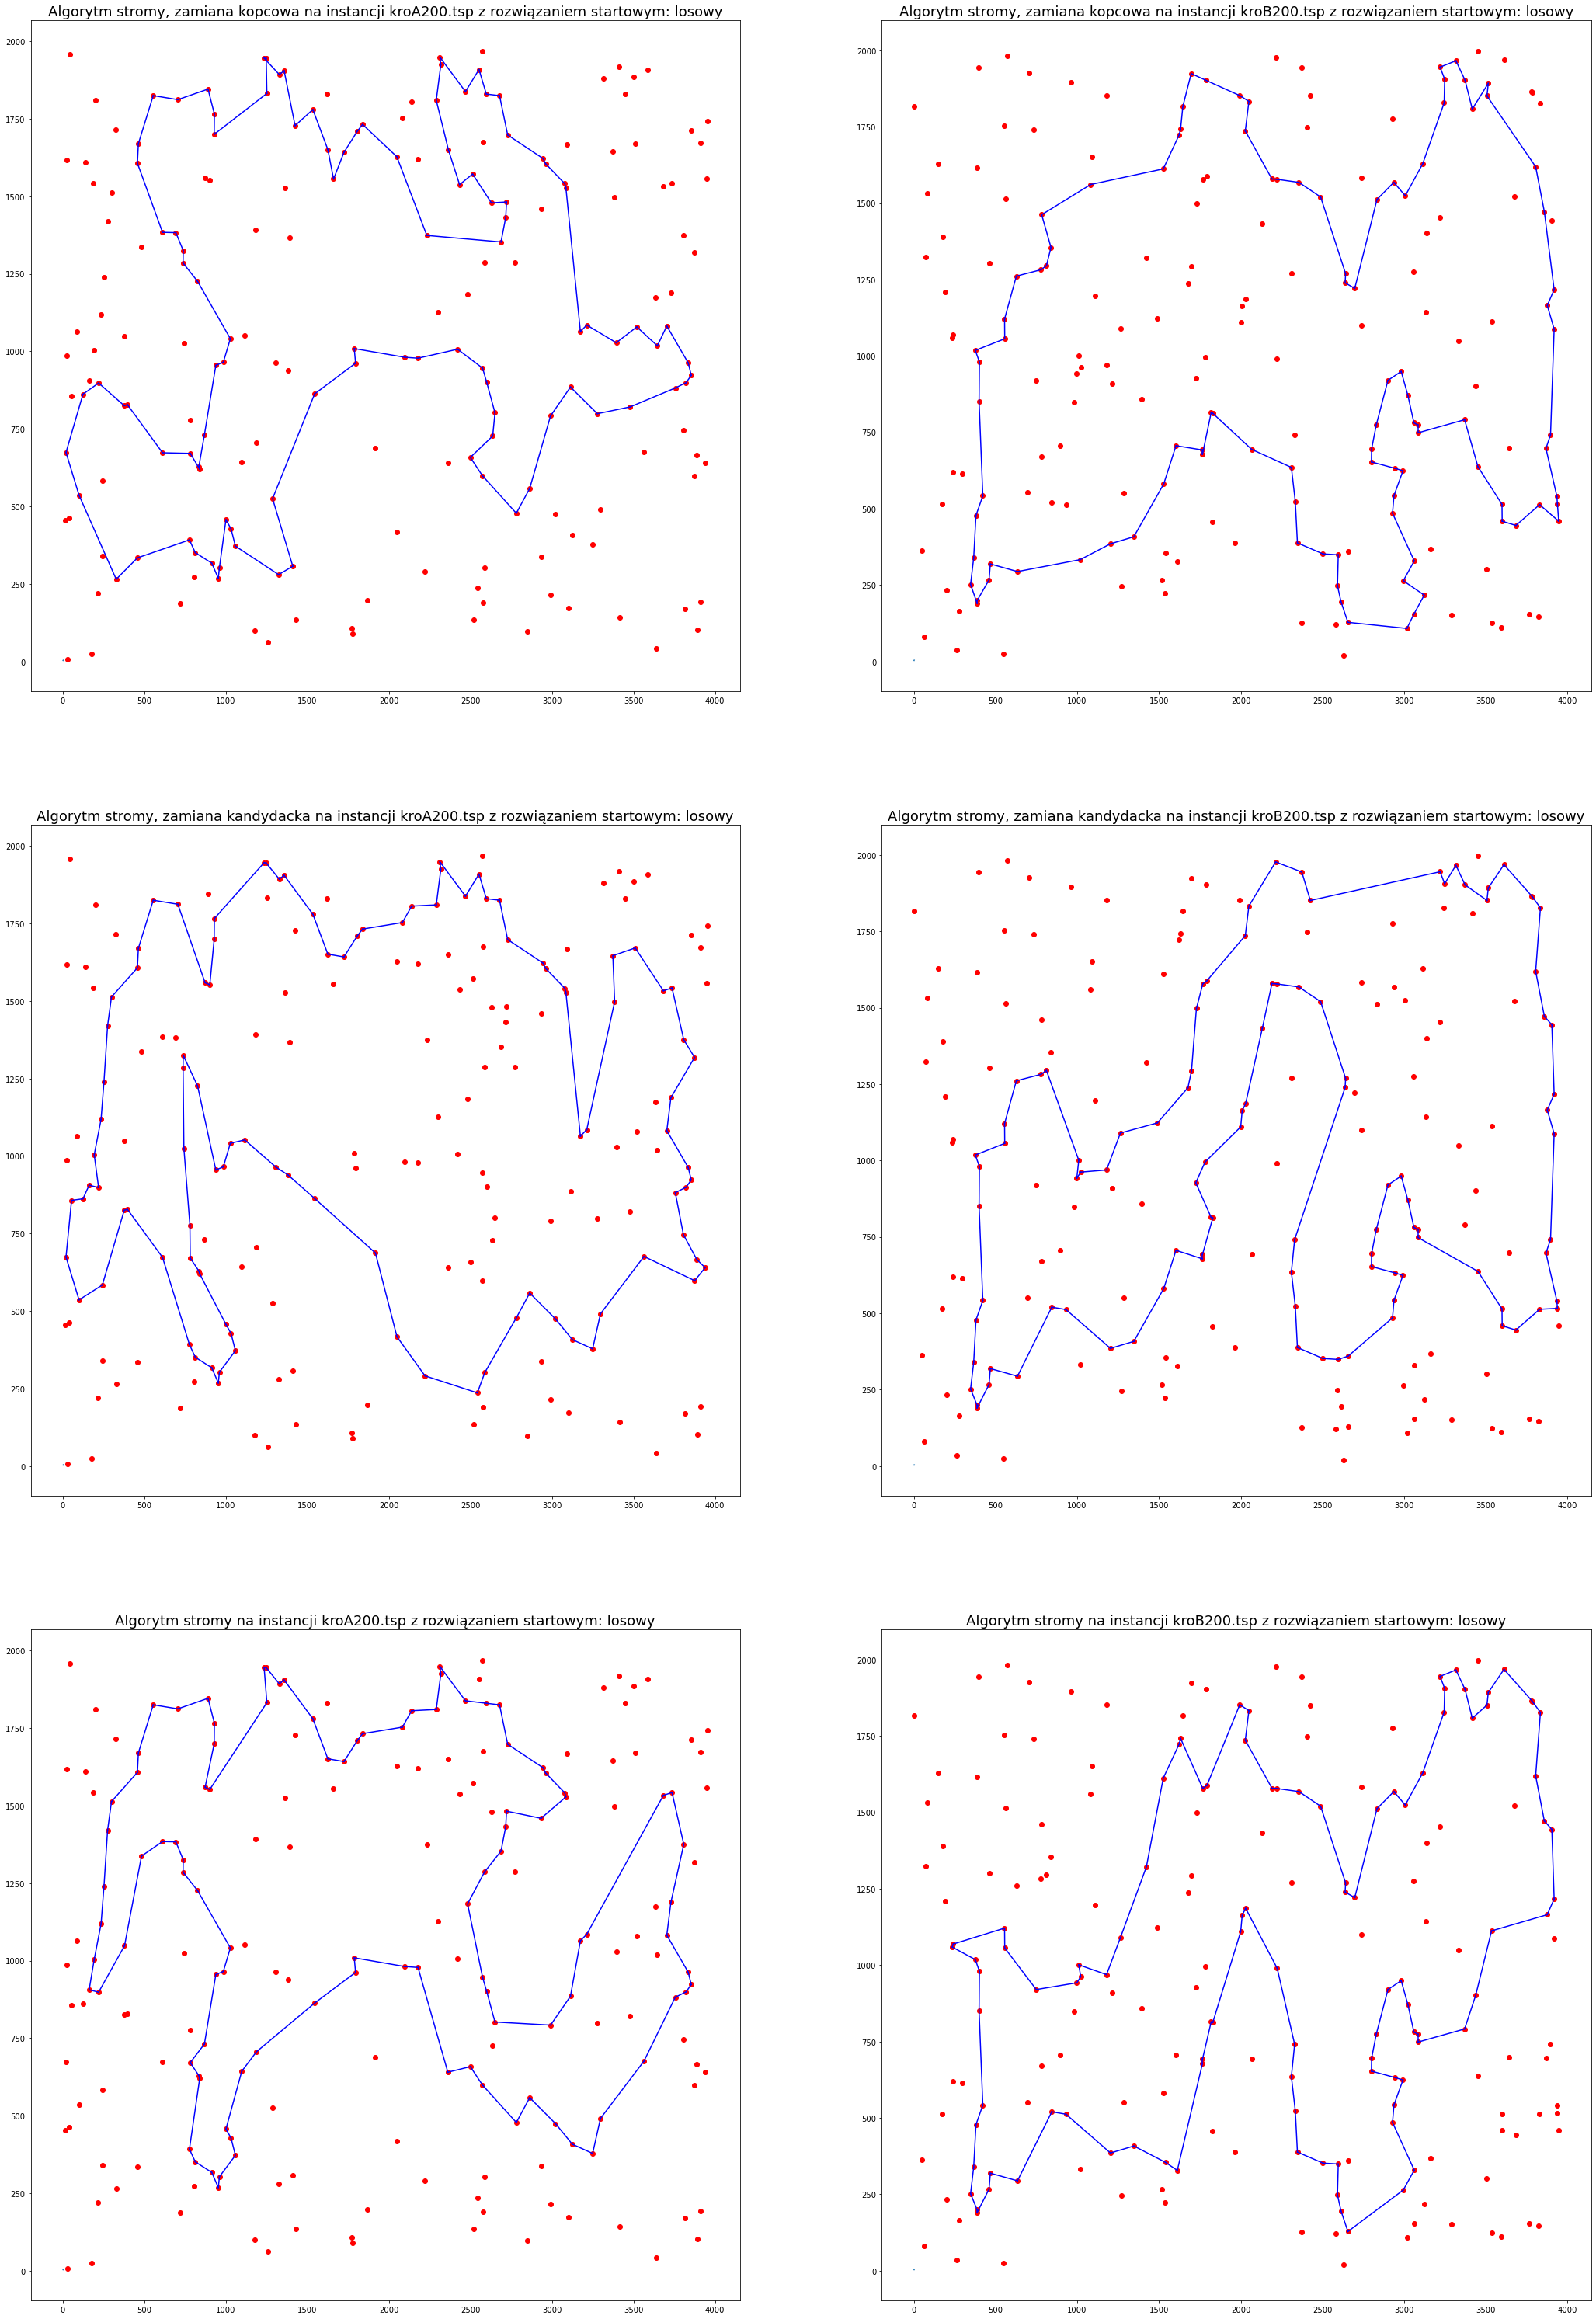

In [109]:
def print_map(res, path, ax):
    ax.plot([1,2], [3,4])
    ln=len(path)
    for x, v1 in enumerate(path):
        v2=path[(x+1)%ln]
        ax.plot([res[v1][1], res[v2][1]], [res[v1][2], res[v2][2]], color='blue')
    ax.scatter([x[1] for x in res], [x[2] for x in res], color='red')

mapp={'kroA200.tsp':0, 'kroB200.tsp':1, 'steep':2, 
     'steep with candidates':1, 'steep with heap':0,
     'random':0, '2reg-2':1}

naming={'steep':'stromy', 'steep with candidates': 'stromy, zamiana kandydacka',
        'steep with heap': 'stromy, zamiana kopcowa',
       'random':'losowy', '2reg-2':'2-żal 2.0'}

all_solutions=len(reality)

for y in post_reality:
    typic=18
    plots=len(reality)
    fig, ax=plt.subplots(plots, 2, figsize=(2*typic, plots*typic))
    if plots==1:
        ax=[ax]
        
    for x in system:
        if x[1]!=y[0]:
            continue
        col=mapp[x[0]]
        row=mapp[x[2]]
        print_map(properties[x[0]]['res'], system[x]['path'], ax[row][col])
        ax[row][col].set_title(f'Algorytm {naming[x[2]]} na instancji {x[0]} z rozwiązaniem startowym: {naming[x[1]]}', size=18)
    plt.savefig(f"heury_{y[0]}.svg", bbox_inches="tight")

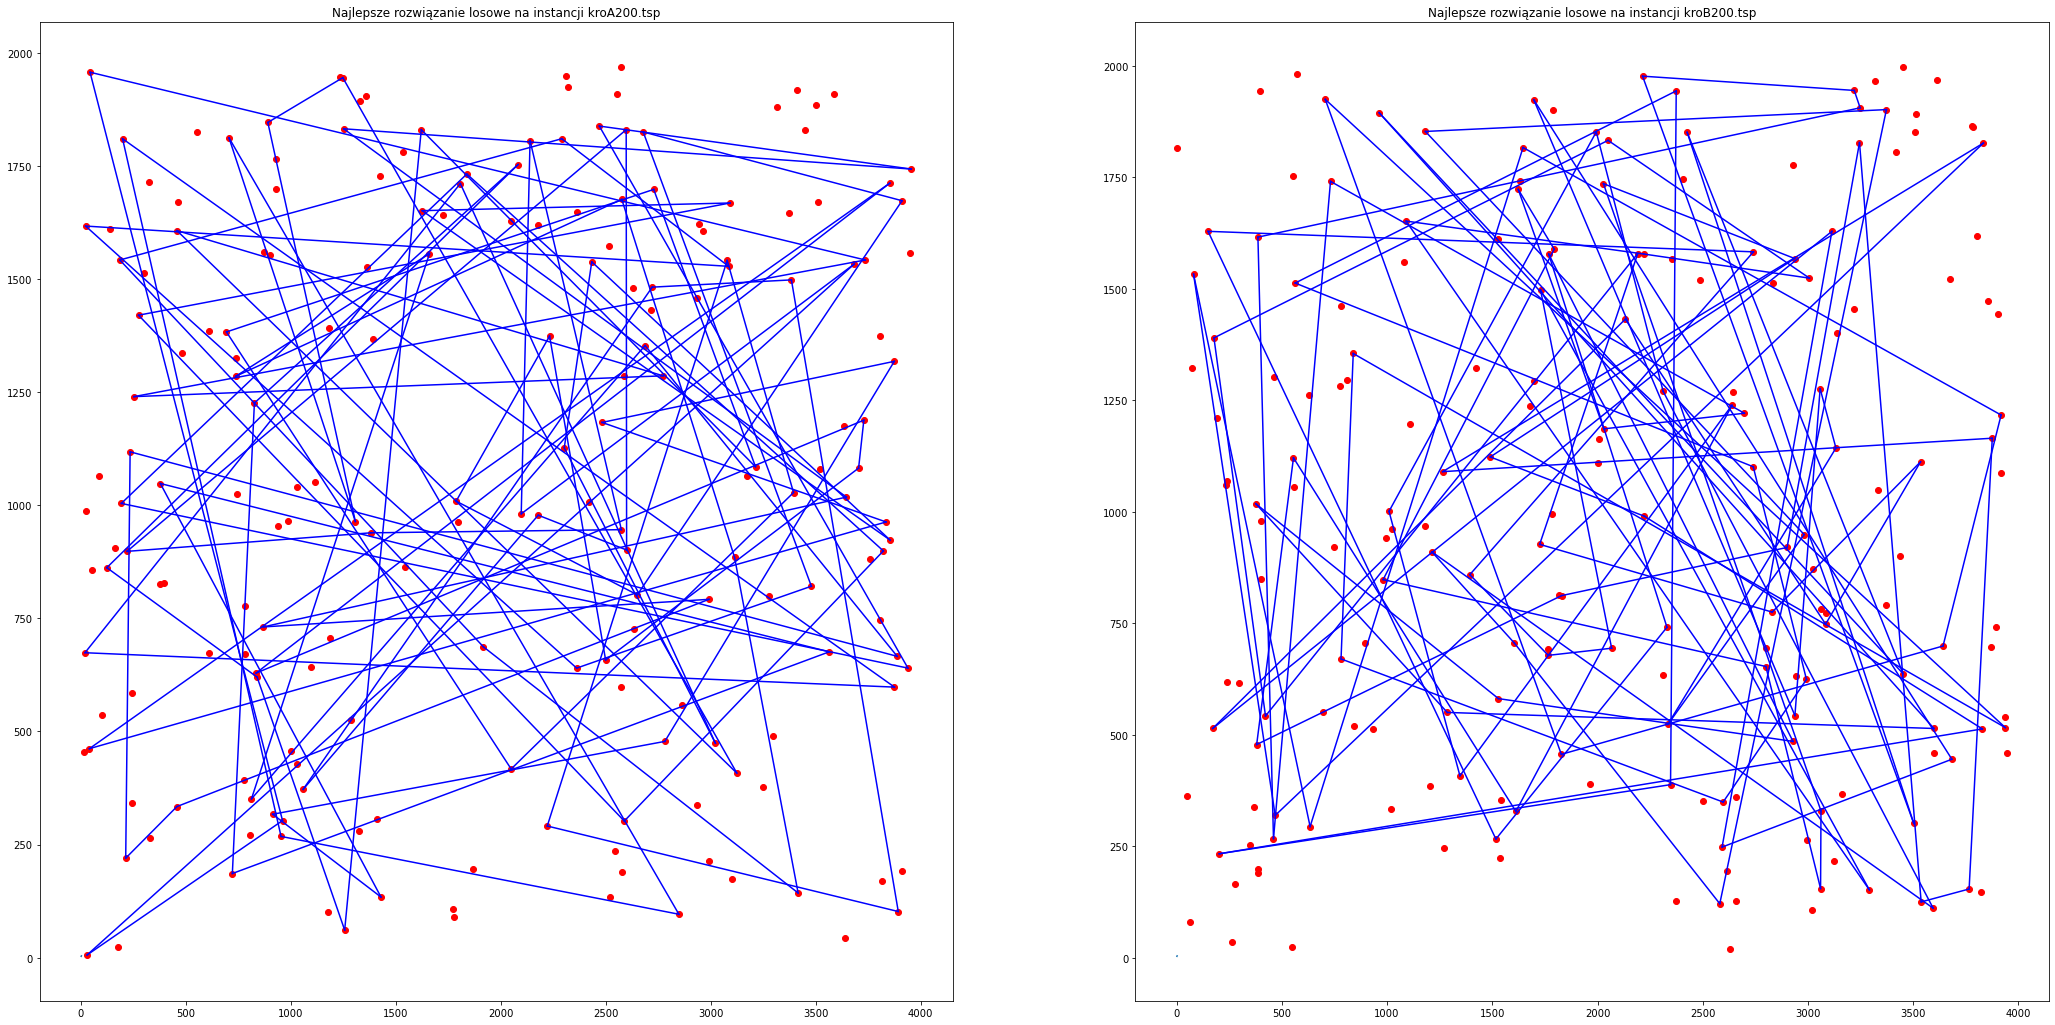

In [110]:
typic=18
fig, ax=plt.subplots(1, 2, figsize=(2*typic, typic))
for i, x in enumerate(properties):
    print_map(properties[x]['res'], properties[x]['bare_path'].pathway, ax[i])
    ax[i].set_title(f'Najlepsze rozwiązanie losowe na instancji {x}')
plt.savefig(f"bieda_heury.svg")

In [111]:
neo_naming={
    'steep':('stromy', 'żadna'), 'steep with candidates':('stromy', 'kandydacka'), 
    'steep with heap':('stromy', 'kolejka')
}

for x in system:
    print(f'{x[0]} & {neo_naming[x[2]][0]} & {neo_naming[x[2]][1]} & {naming[x[1]]}', end='')
    for y in system[x]:
        if y!='path':
            print(f' & {system[x][y]:.2f}', end='')
    print('\\\\ \\hline')

kroA200.tsp & stromy & kolejka & losowy & 14463.00 & 16265.00 & 15168.80 & 0.83 & 0.99 & 0.91\\ \hline
kroA200.tsp & stromy & żadna & losowy & 14181.00 & 16423.00 & 15220.30 & 2.46 & 3.05 & 2.74\\ \hline
kroA200.tsp & stromy & kandydacka & losowy & 14363.00 & 16662.00 & 15319.10 & 0.28 & 0.33 & 0.31\\ \hline
kroB200.tsp & stromy & kolejka & losowy & 13287.00 & 16379.00 & 15147.30 & 0.74 & 1.07 & 0.93\\ \hline
kroB200.tsp & stromy & żadna & losowy & 13685.00 & 15850.00 & 14830.20 & 2.62 & 3.10 & 2.87\\ \hline
kroB200.tsp & stromy & kandydacka & losowy & 13913.00 & 18085.00 & 15611.60 & 0.26 & 0.37 & 0.32\\ \hline


In [112]:
print(system_starter)

{('kroA200.tsp', 'random'): {'min_res': 156473, 'max_res': 181230, 'avg_res': 163404.0}, ('kroB200.tsp', 'random'): {'min_res': 149016, 'max_res': 175515, 'avg_res': 165315.50000000003}}


In [8]:
import heapq

h = []
heapq.heappush(h, (5, {'a':['write code', "BENIZZII"], 'b':312}))
heapq.heappush(h, (7, 'release product'))
heapq.heappush(h, (1, 'write spec'))
heapq.heappush(h, (3, 'create tests'))
falka=heapq.heappop(h)
print(h, falka)

[(3, 'create tests'), (7, 'release product'), (5, {'a': ['write code', 'BENIZZII'], 'b': 312})] (1, 'write spec')
